In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
from rfactor.process import ErosivityData

In [3]:
fmap_rainfall = Path(r"./tests/data/test_rainfalldata")
fmap_erosivity = Path(r"./tests/data/test_erosivitydata/") # Folder path where results are written to (see above).

# Erosivity calculation

Input is a rainfall time series:

In [4]:
all_rainfall = pd.read_csv("./tests/data/demo_rainfall.csv", parse_dates=[0])

In [5]:
all_rainfall.head()

,datetime,rain_mm,station
0,2018-01-01 02:10:00,0.27,P01_001
1,2018-01-01 02:20:00,0.02,P01_001
2,2018-01-01 03:10:00,0.48,P01_001
3,2018-01-01 07:40:00,0.22,P01_001
4,2018-01-01 07:50:00,0.09,P01_001


Algorithm works on year/station basis, so let's pick a year and a station for further development:

In [6]:
P01_001_2018 = all_rainfall[(all_rainfall["station"] == "P01_001") & 
                            (all_rainfall["datetime"].dt.year == 2018)].copy()

<AxesSubplot:xlabel='datetime'>

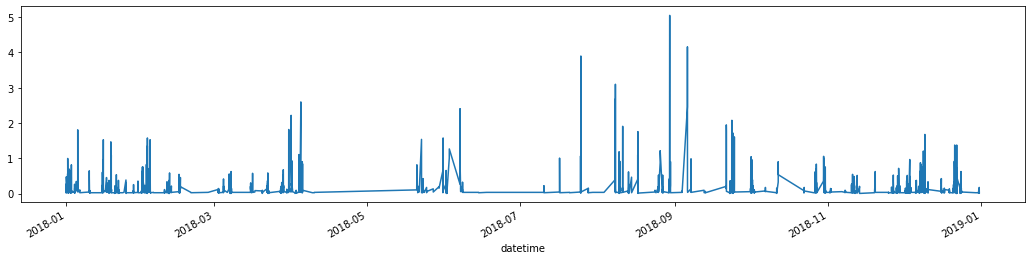

In [7]:
P01_001_2018.set_index("datetime")["rain_mm"].plot(figsize=(18, 4))

In [8]:
P01_001_2018.head()

,datetime,rain_mm,station
0,2018-01-01 02:10:00,0.27,P01_001
1,2018-01-01 02:20:00,0.02,P01_001
2,2018-01-01 03:10:00,0.48,P01_001
3,2018-01-01 07:40:00,0.22,P01_001
4,2018-01-01 07:50:00,0.09,P01_001


In [9]:
# From datetime to minutes difference since start of the year
start_shift = (P01_001_2018.loc[0, "datetime"] - pd.Timestamp("2018-01-01")).total_seconds() /60.
P01_001_2018["min_since_start_year"] = P01_001_2018["datetime"].diff().dt.total_seconds().cumsum() /60. + start_shift
P01_001_2018.loc[0, "min_since_start_year"] = start_shift

In [10]:
P01_001_2018.head()

,datetime,rain_mm,station,min_since_start_year
0,2018-01-01 02:10:00,0.27,P01_001,130.0
1,2018-01-01 02:20:00,0.02,P01_001,140.0
2,2018-01-01 03:10:00,0.48,P01_001,190.0
3,2018-01-01 07:40:00,0.22,P01_001,460.0
4,2018-01-01 07:50:00,0.09,P01_001,470.0


## The erosivity implementation

### 1. Define starting point the individual rain events

In [12]:
event_split = "6 hours"

In [13]:
P01_001_2018["event_start"] = False
P01_001_2018.loc[P01_001_2018["datetime"].diff() >= event_split, "event_start"] = True  # var c in matlab
P01_001_2018.loc[0, "event_start"] = True

In [14]:
max_idx_distance = pd.Series(P01_001_2018[P01_001_2018["event_start"] == True].index).diff().max() #var max in matlab
max_idx_distance

135.0

__?? `max` is the maximum distance in terms of index difference -> also in terms of time the longest event?__

-> use is to define the size of the matrix in the next step to make sure the longest event fits

### 2. Isolate the individual rain events -> I add an event idx

In [15]:
P01_001_2018["event_idx"] = P01_001_2018["event_start"].cumsum()

In [16]:
P01_001_2018.head(10)

,datetime,rain_mm,station,min_since_start_year,event_start,event_idx
0,2018-01-01 02:10:00,0.27,P01_001,130.0,True,1
1,2018-01-01 02:20:00,0.02,P01_001,140.0,False,1
2,2018-01-01 03:10:00,0.48,P01_001,190.0,False,1
3,2018-01-01 07:40:00,0.22,P01_001,460.0,False,1
4,2018-01-01 07:50:00,0.09,P01_001,470.0,False,1
5,2018-01-01 14:30:00,0.08,P01_001,870.0,True,2
6,2018-01-01 14:40:00,0.19,P01_001,880.0,False,2
7,2018-01-01 14:50:00,0.21,P01_001,890.0,False,2
8,2018-01-01 15:00:00,0.20,P01_001,900.0,False,2
9,2018-01-01 15:10:00,0.15,P01_001,910.0,False,2


__What about lines 72-86 in matlab? add time steps with zero-rain values?__

-> probably not required if everything fits in groupby approach?

### 3a. Cumulative rain for each event

In [17]:
P01_001_2018["event_rain_cum"] = P01_001_2018.groupby("event_idx")["rain_mm"].cumsum()

In [18]:
P01_001_2018.head()

,datetime,rain_mm,station,min_since_start_year,event_start,event_idx,event_rain_cum
0,2018-01-01 02:10:00,0.27,P01_001,130.0,True,1,0.27
1,2018-01-01 02:20:00,0.02,P01_001,140.0,False,1,0.29
2,2018-01-01 03:10:00,0.48,P01_001,190.0,False,1,0.77
3,2018-01-01 07:40:00,0.22,P01_001,460.0,False,1,0.99
4,2018-01-01 07:50:00,0.09,P01_001,470.0,False,1,1.08


### 3b. Rain energy

Example with a single event

In [19]:
temp = P01_001_2018[P01_001_2018["event_idx"] == 1].copy()

In [20]:
temp["rain_energy"] = 0.1112*((temp["rain_mm"]*6.)**0.31)*temp["rain_mm"]

__line 105, should it be j or 1?__

```
% j is currently 135 and NOT 1
pluviophase(5,j,i)=0.1112*(pluviophase(4,j,i)^0.31);  % berekenen van neerslagenergie per mm
```

In [21]:
temp["rain_energy"].sum() # to make comparible with matlab add `- 0.034867`

0.1450401392190872

In [22]:
temp.head()

,datetime,rain_mm,station,min_since_start_year,event_start,event_idx,event_rain_cum,rain_energy
0,2018-01-01 02:10:00,0.27,P01_001,130.0,True,1,0.27,0.034867
1,2018-01-01 02:20:00,0.02,P01_001,140.0,False,1,0.29,0.001153
2,2018-01-01 03:10:00,0.48,P01_001,190.0,False,1,0.77,0.074090
3,2018-01-01 07:40:00,0.22,P01_001,460.0,False,1,0.99,0.026663
4,2018-01-01 07:50:00,0.09,P01_001,470.0,False,1,1.08,0.008268


In [23]:
def rain_energy_per_unit(rain):
    """"""
    rain_energy = 0.1112*((rain*6.)**0.31)*rain
    return rain_energy.sum()

In [24]:
rain_energy_per_unit(temp["rain_mm"])

0.1450401392190872

Apply the calculation to the entire set of defined rain events:

In [25]:
P01_001_2018["event_energy"] = P01_001_2018.groupby("event_idx")["rain_mm"].transform(rain_energy_per_unit)

In [26]:
P01_001_2018.head()

,datetime,rain_mm,station,min_since_start_year,event_start,event_idx,event_rain_cum,event_energy
0,2018-01-01 02:10:00,0.27,P01_001,130.0,True,1,0.27,0.14504
1,2018-01-01 02:20:00,0.02,P01_001,140.0,False,1,0.29,0.14504
2,2018-01-01 03:10:00,0.48,P01_001,190.0,False,1,0.77,0.14504
3,2018-01-01 07:40:00,0.22,P01_001,460.0,False,1,0.99,0.14504
4,2018-01-01 07:50:00,0.09,P01_001,470.0,False,1,1.08,0.14504


### 4. Maximum intensity within 30 minutes

First work on a subset of the data:

In [27]:
temp = P01_001_2018[P01_001_2018["event_idx"] == 1].copy()

In [28]:
temp.head()

,datetime,rain_mm,station,min_since_start_year,event_start,event_idx,event_rain_cum,event_energy
0,2018-01-01 02:10:00,0.27,P01_001,130.0,True,1,0.27,0.14504
1,2018-01-01 02:20:00,0.02,P01_001,140.0,False,1,0.29,0.14504
2,2018-01-01 03:10:00,0.48,P01_001,190.0,False,1,0.77,0.14504
3,2018-01-01 07:40:00,0.22,P01_001,460.0,False,1,0.99,0.14504
4,2018-01-01 07:50:00,0.09,P01_001,470.0,False,1,1.08,0.14504


__- Are the lines #L134-L144 effectively used in the code? In lines #L149-L150 the variables are overwritten (also warning by matlab itself__

__- Why is on line #L159 a factor 2 required?__

__- Why is on line #L130 the lenght of the interval only 20minutes? If the concept is 20 + 5 min in each direction of the interval, one would assume 10' input data? Is this a valid assumption as I do not see any input check and other steps are based on checking the diff?__

__- lines 132-133 can hace side effects as well and - I think - only works as all series are prolonged during calculation (second dimension); maxprecip30min should not be overwritten as such__

A naive implementation reproducing the matlab implementation:

In [29]:
def maximum_intensity_matlab_clone(df):
    """Apply for a single_event method of Matlab implementation (Verstraete)"""
    
    df["minutes_since"] = (df["datetime"] - pd.Timestamp("2018-01-01")).dt.total_seconds().values/60

    timestamps = df["minutes_since"].values
    rain = df["rain_mm"].values
    rain_cum = df["event_rain_cum"].values

    maxprecip_30min = 0.
    max_p30 = 0.

    if timestamps[-1] - timestamps[0] <= 30:
        maxprecip_30min = rain[0]*2  # *2 to mimick matlab

    for idx in range(len(df)-1):

        begin_30min = timestamps[idx]
        eind_30min = timestamps[idx] + 20
        begin_rain = rain_cum[idx] - rain[idx]
        if timestamps[idx + 1] > eind_30min: # next timestamp later than 30minutes interval
            precip_30min = rain[idx]        

        eind_rain = np.interp(eind_30min, timestamps, rain_cum)    
        precip_30min = eind_rain - begin_rain;

        if precip_30min > maxprecip_30min:
            maxprecip_30min = precip_30min

    return maxprecip_30min*2

In [30]:
max_intensity_event_matlab_clone = (P01_001_2018.groupby("event_idx")
 .apply(maximum_intensity_matlab_clone)
 .rename("max_30min_intensity_clone")
 .reset_index())

In [31]:
# Single measurement events
# P01_001_2018[P01_001_2018.groupby("event_idx")["station"].transform(len) == 1]

In [32]:
P01_001_2018 = pd.merge(P01_001_2018, max_intensity_event_matlab_clone, how="left")

#### intermezzo _? Is it an option to change the algorithm on defining the max intensity ??_  

Alternative implementations to extract the max intensity of a 30min interval:

1. Rely on linear interpolation (cfr. matlab implementation) -> assume missing data is not zero

- interpolate linearly to interval (in this case 10min) of the data series (max value) 
- rolling interval of 30 minutes 
- take maximum of rolling interval sum of the rainfall within that period

:-) works for different time series intervals; :-( interpolation error as linear interpolation induces errors (overestimation)

In [33]:
time_series_resampled = temp.resample("10Min", on="datetime")["rain_mm"].max() # missing 10min are now Nan
time_series_resampled_interp = time_series_resampled.interpolate(method='linear')
rolling_sum = time_series_resampled_interp.rolling("30Min").sum()
rolling_sum.max()

1.411111111111111

In [34]:
def maximum_intensity_interpolate(df, interval="30Min", input_freq="10Min"):
    """Apply for a single_event method with linear interpolation"""
    time_series_resampled = df.resample(input_freq, on="datetime")["rain_mm"].max()
    time_series_resampled_interp = time_series_resampled.interpolate(method='linear')
    rolling_sum = time_series_resampled_interp.rolling(interval).sum()
    return rolling_sum.max() * 2   # formula requires mm/hr, intensity is on half an hour

2. Resample with the available data directly

- using the data available, rolling/resample over 30min interval directly
- take the maximum of all intervals

(This is equivalent with the previous method, but instead of interpolation, missing intervals are assumed to have no rainfall.)

:-) straight forward using available data only; :-( probably an underestimation?

In [35]:
temp.rolling("30Min", on="datetime")["rain_mm"].sum().max()

0.48

In [36]:
def maximum_intensity_fillna(df, interval="30Min", input_freq="10Min"):
    """Apply for a single_event method with zero values for no value"""
    # formula requires mm/hr, intensity is on half an hour
    return df.rolling("30Min", on="datetime")["rain_mm"].sum().max() *2

For ilustration, the result would be the same as doing:

```
time_series_resampled = temp.resample("10Min", on="datetime")["rain_mm"].max() # missing 10min are now Nan
time_series_resampled_interp = time_series_resampled.fillna(value=0)
rolling_sum = time_series_resampled_interp.rolling("30Min").sum()
rolling_sum.max()
```

Let's compare these methods...

In [37]:
# run on the single event
(maximum_intensity_fillna(temp, interval="30Min", input_freq="10Min"), 
 maximum_intensity_interpolate(temp, interval="30Min", input_freq="10Min"))

(0.96, 2.822222222222222)

Apply to the entire set of events:

In [38]:
max_intensity_event_interpolate = (P01_001_2018.groupby("event_idx")[["datetime", "rain_mm"]]
 .apply(maximum_intensity_interpolate)
 .rename("max_30min_intensity_interpolate")
 .reset_index())

max_intensity_event_fillna = (P01_001_2018.groupby("event_idx")[["datetime", "rain_mm"]]
 .apply(maximum_intensity_fillna)
 .rename("max_30min_intensity_fillna")
 .reset_index())

In [41]:
max_intensity_event_fillna.shape

(140, 2)

In [42]:
P01_001_2018 = pd.merge(P01_001_2018, max_intensity_event_interpolate, how="left")
P01_001_2018 = pd.merge(P01_001_2018, max_intensity_event_fillna, how="left")

In [43]:
P01_001_2018.head(10)

,datetime,rain_mm,station,min_since_start_year,event_start,event_idx,event_rain_cum,event_energy,max_30min_intensity_clone,max_30min_intensity_interpolate,max_30min_intensity_fillna
0,2018-01-01 02:10:00,0.27,P01_001,130.0,True,1,0.27,0.145040,0.992593,2.822222,0.96
1,2018-01-01 02:20:00,0.02,P01_001,140.0,False,1,0.29,0.145040,0.992593,2.822222,0.96
2,2018-01-01 03:10:00,0.48,P01_001,190.0,False,1,0.77,0.145040,0.992593,2.822222,0.96
3,2018-01-01 07:40:00,0.22,P01_001,460.0,False,1,0.99,0.145040,0.992593,2.822222,0.96
4,2018-01-01 07:50:00,0.09,P01_001,470.0,False,1,1.08,0.145040,0.992593,2.822222,0.96
5,2018-01-01 14:30:00,0.08,P01_001,870.0,True,2,0.08,1.530117,3.280000,3.530000,3.28
6,2018-01-01 14:40:00,0.19,P01_001,880.0,False,2,0.27,1.530117,3.280000,3.530000,3.28
7,2018-01-01 14:50:00,0.21,P01_001,890.0,False,2,0.48,1.530117,3.280000,3.530000,3.28
8,2018-01-01 15:00:00,0.20,P01_001,900.0,False,2,0.68,1.530117,3.280000,3.530000,3.28
9,2018-01-01 15:10:00,0.15,P01_001,910.0,False,2,0.83,1.530117,3.280000,3.530000,3.28


The difference between the methods:

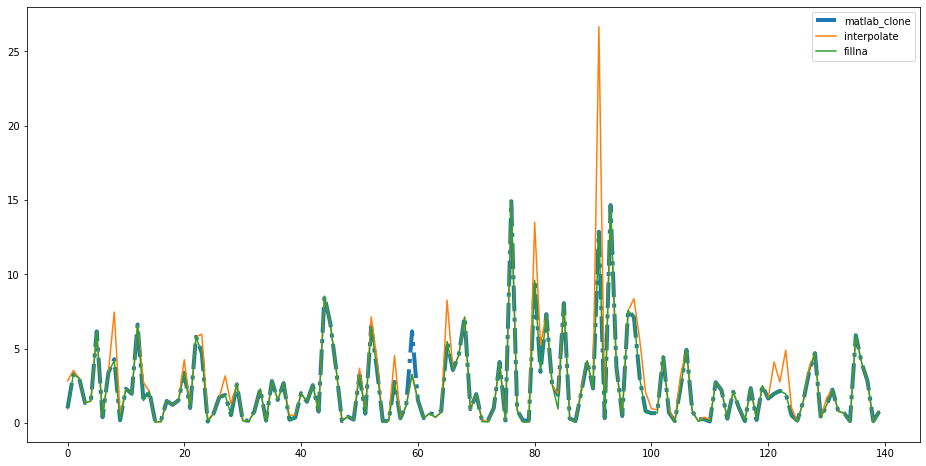

In [44]:
fig, ax = plt.subplots(figsize=(16, 8))
max_intensity_event_matlab_clone["max_30min_intensity_clone"].plot(ax=ax, label="matlab_clone", 
                                                                   linewidth=4, linestyle='-.')
max_intensity_event_interpolate["max_30min_intensity_interpolate"].plot(ax=ax, label="interpolate")
max_intensity_event_fillna["max_30min_intensity_fillna"].plot(ax=ax, label="fillna")
ax.legend()

In [46]:
P01_001_2018.head()

,datetime,rain_mm,station,min_since_start_year,event_start,event_idx,event_rain_cum,event_energy,max_30min_intensity_clone,max_30min_intensity_interpolate,max_30min_intensity_fillna
0,2018-01-01 02:10:00,0.27,P01_001,130.0,True,1,0.27,0.14504,0.992593,2.822222,0.96
1,2018-01-01 02:20:00,0.02,P01_001,140.0,False,1,0.29,0.14504,0.992593,2.822222,0.96
2,2018-01-01 03:10:00,0.48,P01_001,190.0,False,1,0.77,0.14504,0.992593,2.822222,0.96
3,2018-01-01 07:40:00,0.22,P01_001,460.0,False,1,0.99,0.14504,0.992593,2.822222,0.96
4,2018-01-01 07:50:00,0.09,P01_001,470.0,False,1,1.08,0.14504,0.992593,2.822222,0.96


### 5. Gather results for each event

In [100]:
P01_001_2018.head()

,datetime,rain_mm,station,min_since_start_year,event_start,event_idx,event_rain_cum,event_energy,max_30min_intensity_clone,max_30min_intensity_interpolate,max_30min_intensity_fillna
0,2018-01-01 02:10:00,0.27,P01_001,130.0,True,1,0.27,0.14504,0.992593,2.822222,0.96
1,2018-01-01 02:20:00,0.02,P01_001,140.0,False,1,0.29,0.14504,0.992593,2.822222,0.96
2,2018-01-01 03:10:00,0.48,P01_001,190.0,False,1,0.77,0.14504,0.992593,2.822222,0.96
3,2018-01-01 07:40:00,0.22,P01_001,460.0,False,1,0.99,0.14504,0.992593,2.822222,0.96
4,2018-01-01 07:50:00,0.09,P01_001,470.0,False,1,1.08,0.14504,0.992593,2.822222,0.96


Extract summary for each event:

In [105]:
columns = ["event_rain_cum", "max_30min_intensity_clone", "event_energy", "datetime"]
P01_001_2018_events = P01_001_2018.groupby("event_idx")[columns].agg({"datetime": "first",
                                                                      "event_rain_cum": "last", 
                                                                      "max_30min_intensity_clone": "last", 
                                                                      "event_energy": "last", 
                                                                     })
P01_001_2018_events

,datetime,event_rain_cum,max_30min_intensity_clone,event_energy
event_idx,,,,
1,2018-01-01 02:10:00,1.08,0.992593,0.145040
2,2018-01-01 14:30:00,11.29,3.280000,1.530117
3,2018-01-02 16:30:00,7.76,3.000000,0.996561
4,2018-01-04 09:10:00,2.34,1.340000,0.242004
5,2018-01-05 02:20:00,1.56,1.480000,0.190453
...,...,...,...,...
136,2018-12-20 10:30:00,17.27,5.900000,2.609841
137,2018-12-21 22:40:00,5.05,4.040000,0.802073
138,2018-12-23 10:00:00,9.32,2.820000,1.064159


In [120]:
P01_001_2018_events["erosivity"] = P01_001_2018_events["event_energy"] * P01_001_2018["max_30min_intensity_clone"]

Add cumulative value of the events combined:

In [121]:
P01_001_2018_events["all_events_cum"] = P01_001_2018_events["event_rain_cum"].shift(1).cumsum()

Add days from start of year (conform matlab implementation):

In [136]:
P01_001_2018_events["days_since_start_year"] = (P01_001_2018_events["datetime"] - pd.Timestamp("2018-01-01")).dt.total_seconds() / 60. / 1440.

Exclude events with total rainfall lower than threshold:

In [150]:
MIN_CUMUL = 1.27

#P01_001_2018_events.loc[P01_001_2018_events["event_rain_cum"] < MIN_CUMUL, 
#                        ["erosivity", "all_events_cum", 
#                         "max_30min_intensity_clone", "days_since_start_year"]] = 0.

P01_001_2018_events_subset = P01_001_2018_events[P01_001_2018_events["event_rain_cum"] > MIN_CUMUL]
P01_001_2018_events_subset

,datetime,event_rain_cum,max_30min_intensity_clone,event_energy,erosivity,all_events_cum,days_since_start_year,erosivity_cum
event_idx,,,,,,,,
2,2018-01-01 14:30:00,11.29,3.28,1.530117,1.518783,1.08,0.604167,1.518783
3,2018-01-02 16:30:00,7.76,3.00,0.996561,0.989179,12.37,1.687500,2.507961
4,2018-01-04 09:10:00,2.34,1.34,0.242004,0.240211,20.13,3.381944,2.748173
5,2018-01-05 02:20:00,1.56,1.48,0.190453,0.624687,22.47,4.097222,3.372859
6,2018-01-05 16:00:00,3.33,6.16,0.681102,2.234014,24.03,4.666667,5.606873
...,...,...,...,...,...,...,...,...
132,2018-12-15 21:30:00,5.07,2.24,0.620312,0.831219,475.20,348.895833,196.924103
136,2018-12-20 10:30:00,17.27,5.90,2.609841,3.497187,482.13,353.437500,200.421290
137,2018-12-21 22:40:00,5.05,4.04,0.802073,1.074777,499.40,354.944444,201.496067


__?? Should all_events_cum include the events that were excluded as below threshold?__

### 6. Cumulative erosivity

In [151]:
P01_001_2018_events_subset["erosivity_cum"] = P01_001_2018_events_subset["erosivity"].cumsum()

In [152]:
P01_001_2018_events_subset.head(10)

,datetime,event_rain_cum,max_30min_intensity_clone,event_energy,erosivity,all_events_cum,days_since_start_year,erosivity_cum
event_idx,,,,,,,,
2,2018-01-01 14:30:00,11.29,3.28,1.530117,1.518783,1.08,0.604167,1.518783
3,2018-01-02 16:30:00,7.76,3.00,0.996561,0.989179,12.37,1.687500,2.507961
4,2018-01-04 09:10:00,2.34,1.34,0.242004,0.240211,20.13,3.381944,2.748173
5,2018-01-05 02:20:00,1.56,1.48,0.190453,0.624687,22.47,4.097222,3.372859
6,2018-01-05 16:00:00,3.33,6.16,0.681102,2.234014,24.03,4.666667,5.606873
8,2018-01-10 05:40:00,5.43,3.38,0.722533,2.369909,27.72,9.236111,7.976782
9,2018-01-15 11:50:00,13.21,4.29,1.979756,6.493601,33.15,14.493056,14.470383
11,2018-01-17 03:20:00,1.94,2.30,0.250436,0.821431,46.59,16.138889,15.291814
12,2018-01-18 01:00:00,4.03,1.96,0.477328,1.565637,48.53,17.041667,16.857451


### Derived stats

### Berekenen van maandelijkse erosiviteit

__?? line 212 what about leap years ?__

TO CHECK -> IS THIS correct interpretation of the description/implementation?

In [158]:
# Monthly
P01_001_2018_events_subset.resample("M", on="datetime")["erosivity"].sum()

datetime
2018-01-31    31.686562
2018-02-28    15.290858
2018-03-31    23.226929
2018-04-30     6.863936
2018-05-31     7.255709
2018-06-30     6.589623
2018-07-31    10.451051
2018-08-31    29.999871
2018-09-30    29.633368
2018-10-31    17.677100
2018-11-30     8.328033
2018-12-31    16.080570
Freq: M, Name: erosivity, dtype: float64

In [159]:
# Bi-weekly
P01_001_2018_events_subset.resample("14D", on="datetime")["erosivity"].sum()

datetime
2018-01-01     7.976782
2018-01-15    17.680213
2018-01-29    18.229244
2018-02-12     3.091180
2018-02-26     6.491400
2018-03-12     6.097881
2018-03-26    17.501584
2018-04-09     0.000000
2018-04-23     0.000000
2018-05-07     0.926241
2018-05-21     9.763595
2018-06-04     3.155496
2018-06-18     0.000000
2018-07-02     0.000000
2018-07-16    10.451051
2018-07-30    12.429891
2018-08-13    10.073140
2018-08-27    15.013818
2018-09-10    18.926577
2018-09-24     3.673876
2018-10-08     1.619877
2018-10-22    15.573161
2018-11-05     5.853604
2018-11-19     4.003849
2018-12-03     8.391645
2018-12-17     6.159505
Freq: 14D, Name: erosivity, dtype: float64

-- quick intermediate check --

In [ ]:
# Check if the time difference works   - OK
diffs = np.loadtxt("tests/data/test_rainfalldata/P01_001_2018.txt", usecols=0)
np.testing.assert_allclose(P01_001_2018["diff"].values, diffs)